In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import cv2
from numpy.linalg import norm
import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [8]:
#import data and define the classes
train_data = pd.read_csv('./data/digit/train.csv')
test_data = pd.read_csv('./data/digit/test.csv')
class_names = ['0','1','2','3','4','5','6','7','8','9']

In [26]:
#split out the data into features (pixel values) and categorical labels (digit values 0-9)
train_x = train_data.iloc[:,1:].values.astype('int32') # all pixel values
train_y = train_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits

test_x = test_data.iloc[:,].values.astype('int32') # all pixel values
test_y = test_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits

#reshape the features to be 28x28
train_x = train_x.reshape(train_x.shape[:1] + (28, 28, 1))

test_x = test_x.reshape(test_x.shape[:1] + (28, 28, 1))

# #normalize pixel values using minmax (values between 0 and 1 inclusive)
train_x = train_x / 255
test_x = test_x / 255

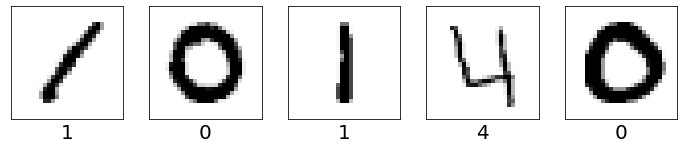

In [10]:
#plot a first 5 of features and labels to check data
plt.figure(figsize=(12,12))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_y[i]],fontsize = 20)
plt.show()

In [11]:
# Deskew images ...
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-3:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*28*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

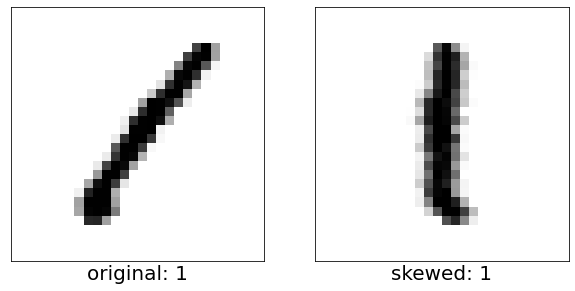

In [27]:
train_deskewed = list(map(deskew, train_x))
test_deskewed = list(map(deskew, test_x))

showInd = 0

class_name = class_names[train_y[showInd]];

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(train_x[showInd].reshape(28,28), cmap=plt.cm.binary)
plt.xlabel('original: ' + class_name,fontsize=20)

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(train_deskewed[showInd], cmap=plt.cm.binary)
plt.xlabel('skewed: ' + class_name,fontsize=20)

plt.show()

In [13]:
# HoG feature descriptor
def HOG(imgs):
    hog = cv2.HOGDescriptor((28,28),(8,8),(4,4),(8,8),9,1,-1,0,0.1,1,32, True)
    hog_descriptors = []
    for img in imgs:
        cv_img = np.around(img*255).astype('uint8')
        hog_descriptors.append(hog.compute(cv_img))

    hog_descriptors = np.squeeze(hog_descriptors)
    return hog_descriptors

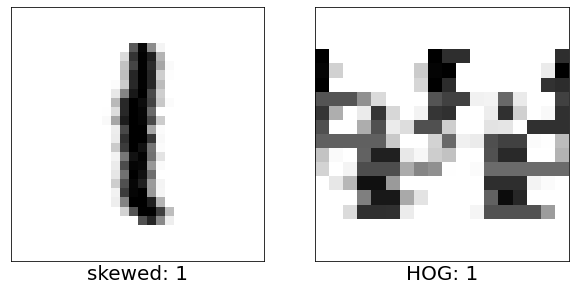

In [14]:
train_hog = HOG(train_deskewed)
test_hog = HOG(test_deskewed)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(train_deskewed[showInd].reshape(28,28), cmap=plt.cm.binary)
plt.xlabel('skewed: ' + class_name,fontsize=20)

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(train_hog[showInd].reshape(18,18), cmap=plt.cm.binary)
plt.xlabel('HOG: ' + class_name,fontsize=20)

plt.show()

In [15]:
# Evaluation cross_validation
clf = svm.SVC(kernel='linear', C=8)
scores = cross_val_score(clf, train_hog, train_y, cv=5)
print(scores)

[0.98690476 0.98761905 0.98690476 0.98761905 0.98690476]


In [17]:
clf.fit(train_hog, train_y)
train_result = clf.predict(train_hog)

err = (train_y != train_result).mean()
print('Accuracy: %.2f %%' % ((1 - err)*100))

Accuracy: 99.98 %


In [24]:
clf.score(test_hog, test_y) * 100

9.89642857142857